## Bank loan risk classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.svm import SVC
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [ ]:
df = pd.read_excel('https://github.com/aphilas/loan-risk/blob/main/Risk%20data.xlsx?raw=true')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # Drop "#Unnamed" colums
# df.head()
df

,ID,AGE,INCOME,GENDER,MARITAL,NUMKIDS,NUMCARDS,HOWPAID,MORTGAGE,STORECAR,LOANS,RISK
0,100756,44,59944,m,married,1,2,monthly,y,2,0,good risk
1,100668,35,59692,m,married,1,1,monthly,y,1,0,bad loss
2,100418,34,59508,m,married,1,1,monthly,y,2,1,good risk
3,100416,34,59463,m,married,0,2,monthly,y,1,1,bad loss
4,100590,39,59393,f,married,0,2,monthly,y,1,0,good risk
...,...,...,...,...,...,...,...,...,...,...,...,...
4112,101121,20,15035,m,married,2,2,weekly,y,1,2,bad profit
4113,101602,23,15032,f,married,1,1,monthly,y,2,2,bad profit
4114,101983,25,15020,f,married,2,0,weekly,y,1,1,bad profit
4115,101819,24,15018,m,married,1,2,monthly,y,1,2,bad profit


In [ ]:
df.describe()

,ID,AGE,INCOME,NUMKIDS,NUMCARDS,STORECAR,LOANS
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,102059.000000,31.819529,25580.211805,1.452514,2.429439,2.515910,1.375759
std,1188.619858,9.876729,8766.867219,1.170579,1.880721,1.352768,0.838183
min,100001.000000,18.000000,15005.000000,0.000000,0.000000,0.000000,0.000000
25%,101030.000000,23.000000,20497.000000,1.000000,1.000000,1.000000,1.000000
50%,102059.000000,31.000000,23490.000000,1.000000,2.000000,2.000000,1.000000
75%,103088.000000,41.000000,27566.000000,2.000000,4.000000,3.000000,2.000000
max,104117.000000,50.000000,59944.000000,4.000000,6.000000,5.000000,3.000000


## Data prep

In [ ]:
target = df.RISK.astype('category').cat.codes

input = df.drop(['ID', 'RISK'], axis='columns')
input.INCOME = pd.cut(input.INCOME, bins=[15000, 20000, 24000, 30000, 42000, 60000], labels=False)
input.AGE = pd.cut(input.AGE, bins=[17, 21, 31, 41, 51], labels=False)
input.NUMKIDS = pd.cut(input.NUMKIDS, bins=[-1,0,1,5 ], labels=False) 
input.NUMCARDS = pd.cut(input.NUMCARDS, bins=[-1,1,2,7 ], labels=False) 
input.STORECAR = pd.cut(input.STORECAR, bins=[-1,1,2,3,6 ], labels=False)
input.LOANS = pd.cut(input.LOANS, bins=[-1,0,1,6 ], labels=False)
input = pd.get_dummies(input, columns=['GENDER', 'MARITAL', 'HOWPAID', 'MORTGAGE'], drop_first=True)
input

,AGE,INCOME,NUMKIDS,NUMCARDS,STORECAR,LOANS,GENDER_m,MARITAL_married,MARITAL_single,HOWPAID_weekly,MORTGAGE_y
0,3,4,1,1,1,0,1,1,0,0,1
1,2,4,1,0,0,0,1,1,0,0,1
2,2,4,1,0,1,1,1,1,0,0,1
3,2,4,0,1,0,1,1,1,0,0,1
4,2,4,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4112,0,0,2,1,0,2,1,1,0,1,1
4113,1,0,1,0,1,2,0,1,0,0,1
4114,1,0,2,0,0,1,0,1,0,1,1
4115,1,0,1,1,0,2,1,1,0,0,1


### Feature selection test

In [ ]:
score_sums = dict()

for i in range(20):
    for column in list(input):
        X_train, X_test, y_train, y_test = train_test_split(input.drop(column, axis='columns'), target, test_size=0.2)
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train,y_train)
        score = knn.score(X_test,y_test)

        try:
            score_sums[column] += score
        except KeyError:
            score_sums[column] = score

scores = sorted([ (score_sums[column] / 20, column) for column in list(input) ], key=lambda v:v[0], reverse=True)

# score of model with respective columns dropped
# appears to be random!?
scores 

# STORECAR, GENDER_m, AGE, HOWPAID_weekly

[(0.7023665048543688, 'GENDER_m'),
 (0.7001213592233012, 'LOANS'),
 (0.7000000000000001, 'MORTGAGE_y'),
 (0.6994538834951456, 'HOWPAID_weekly'),
 (0.6987864077669903, 'AGE'),
 (0.6985436893203884, 'STORECAR'),
 (0.6958131067961166, 'MARITAL_single'),
 (0.6950242718446601, 'NUMCARDS'),
 (0.6945995145631069, 'NUMKIDS'),
 (0.6913228155339806, 'INCOME'),
 (0.6910194174757281, 'MARITAL_married')]

### With a validation set

0.6929611650485437

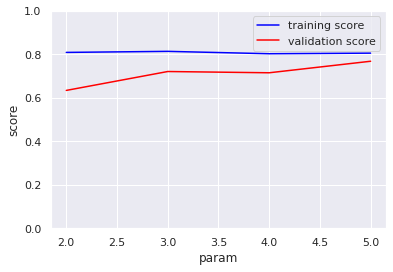

In [ ]:
# 60-20-20
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

### testing n_neighbors param, as an example

# use validation or training set!?
param_range = (2, 3, 4, 5)
train_score, val_score = validation_curve(KNeighborsClassifier(), X_val, y_val, cv=10, param_name='n_neighbors', param_range=param_range)

plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('param')
plt.ylabel('score')

###

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

### With cross-validation

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(input,target)
# score = knn.score(X_test,y_test)
scores = cross_val_score(knn, input, target, cv=10)
scores.mean()

0.6468316679658895

## DT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2)
dtree = DecisionTreeClassifier( max_depth=8)

dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

0.7548543689320388

## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7196601941747572

## SVM

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7609223300970874

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=910b37c8-07c7-4f3d-a1cf-55eb226f4bff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>